In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from random import randrange

# Data for final consumption and total output

We apply our models to the input-output data of Germany. The data
we use for initial output and final consumption per industry, as well as the supply and
demand shock data is taken from:

Pichler, A. and Farmer, J. D. (2021b). Simultaneous supply and demand constraints in
input–output networks: the case of covid-19 in Germany, Italy and Spain (Version V1).
Zenodo. https://doi.org/10.5281/zenodo.4326815

## Final consumption

In [2]:
fdata = pd.read_csv('fdata_ita.csv', sep = ',')
fdata.head()

,Unnamed: 0,f,fmin,fmax,f.maxF,f.maxX
0,A01,23713.831192,0,21345.327192,2.134533e+04,21345.327192
1,A02,1287.390162,0,1238.167593,7.089618e-11,0.000000
2,A03,1144.893223,0,1030.403900,1.030404e+03,1030.403900
3,B,9853.060356,0,8868.240274,6.504931e+03,6504.930858
4,C10-C12,94671.008208,0,85212.776296,3.342065e+04,33420.652971


In [3]:
f_0 = fdata.iloc[:,1].astype('float')
f_max = np.array(fdata.iloc[:,3].astype('float'))

In [4]:
demand_shock = np.zeros(f_max.shape[0])
for i in range (0,f_max.shape[0]):
    demand_shock[i] = round(1- f_max[i]/f_0[i],3)
    
demand_shock = np.array(demand_shock) 

## Total output

In [5]:
xdata =  pd.read_csv('xdata_ita.csv', sep = ',')
xdata.tail()   

,Unnamed: 0,x,xmin,xmax,x.maxF,x.maxX
50,O84,171897.13915,0,171897.139150,170288.802062,170288.802062
51,P85,97595.19695,0,97595.196950,95851.256718,95851.256718
52,Q,197915.54595,0,197915.545950,196575.393859,196575.393859
53,R_S,110531.33285,0,56128.781726,56128.781726,56128.781726
54,T,25597.80370,0,25597.803700,25597.803700,25597.803700


In [6]:
x_0 = xdata.iloc[:,1].astype('float')
x_max = np.array(xdata.iloc[:,3].astype('float'))

In [7]:
supply_shock = np.zeros(x_max.shape[0])
for i in range (0,x_max.shape[0]):
    supply_shock[i] = round(1- x_max[i]/x_0[i],6)
supply_shock = np.array(supply_shock)

In [8]:
critical = pd.read_csv('A.essential3.csv', sep = ',')
critical = np.array(critical.iloc[:55,1:56])

# IO table 

In [9]:
df = pd.read_csv('ita_wiot.csv',sep = ',',low_memory=False)

In [10]:
df = df.iloc[0:55,1:56]
df = df.astype('float')
df.shape

(55, 55)

**Creating matrix A**

In [11]:
A = np.array(df)
N = A.shape[0]
A.shape

(55, 55)

In [12]:
x_0 = np.array(x_0)

In [13]:
f_0 = np.array(f_0)

# Leontief Model

**Calculating equilibrium when x is given**

In [14]:
final_consumption = np.matmul(np.identity(N)-A, x_0)
sum(f_max)/sum(final_consumption)

0.8905066210075246

**Computing equilibrium when f is given**

In [15]:
L = np.linalg.inv(np.identity(N)-A)

In [16]:
total_output = np.matmul(L, f_0)
sum(x_max)/sum(x_0)
#sum(x_max)/sum(total_output)

0.7256416370029234

In [17]:
direct_shock = (sum(x_max)/sum(total_output),sum(f_max)/sum(final_consumption))
direct_shock

(0.7256416370029266, 0.8905066210075246)

# Optimalization

### Feasible Market Allocations
Given exogenous constraints to supply and demand, what is the feasible market allocation that maximizes final consumption and/or total output? The solution needs to lie within exogenous bounds on supply and demand and also needs to satisfy the assumption of Leontief production:

$$ x = Ax + f = Lf $$

We seek market allocations {$x^*$ , $f^*$} that (a) respect the given production recipes $x^*=Lf^*$ and (b) satisfy basic output and demand constraints $x^* \in [0, x^{max}]$ and $f^* \in [0, f^{max}]$.

**Optimization procedure**

As a first case, we determine the market allocation that maximizes gross output under the assumptions specified. Large levels of output indicate high levels of ecomomic activity, which in turn entail high levels of primary factors such as labor compensation. As a second case, we look at market allocations that maximize final comsumption given current production capacities. Due to the linearity of the Leontief framework, the problem boils down to linear programming exercises.

*Maximizing gross output*
$$ \text{max}_f \qquad 1^T(I-A)^{-1}f $$
$$ \text{Subject to} \quad (I-A)^{-1}f \in [0, x^{max}] $$

*Maximizing final consumption*
$$ \text{max}_x \qquad 1^T(I-A)x $$
$$ \text{Subject to} \quad (I-A)x \in [0, f^{max}] $$

### Maximizing total output

In [18]:
def max_output(N,L,A,xmax,fmax):
    z = np.ones(N)
    obj = -np.matmul(np.matrix.transpose(z), L)
    lhs_ineq = np.concatenate((-L,L))
    rhs_ineq = np.concatenate((np.zeros(N), xmax))
    
    bnd = []
    for i in range (0,N):
        bnd.append((0,fmax[i]))
    
    result = linprog(c = obj, A_ub= lhs_ineq, b_ub= rhs_ineq, bounds = bnd)
    
    optimal_output = -result.fun
    
    optimal_f = np.ones(N)
    for i in range(0,N):
        optimal_f[i] = result.x[i]
    
    return result.success, optimal_output/sum(x_0), sum(optimal_f)/sum(f_0)

In [19]:
result = max_output(N,L,A,x_max,f_max)
Max_output = (result[1], result[2])
Max_output

(0.6133400575407387, 0.6399275423015803)

In [20]:
z = np.ones(N)
np.matmul(np.matmul(np.matrix.transpose(z), L), f_max)/sum(x_0)

0.881162794048229

### Maximizing final consumption

In [21]:
def max_consumption(N,L,A,xmax,fmax):
    z = np.ones(N)
    obj2 = -np.matmul(np.matrix.transpose(z), np.identity(N)-A)
    lhs_ineq2 = np.concatenate((-(np.identity(N)-A), np.identity(N)-A))
    rhs_ineq2 = np.concatenate((np.zeros(N), fmax))
    
    bnd2 = []
    for i in range (0,N):
        bnd2.append((0,xmax[i]))
        
    result2 = linprog(c = obj2, A_ub= lhs_ineq2, b_ub= rhs_ineq2, bounds= bnd2)
    optimal_f_2 = -result2.fun
    
    optimal_output_2 = np.ones(N)
    for i in range(0,N):
        optimal_output_2[i] = round(result2.x[i])
        
    return result2.success, sum(optimal_output_2)/sum(x_0), optimal_f_2/sum(f_0)

In [22]:
result2 = max_consumption(N,L,A,x_max,f_max)
Max_consumption = (result2[1], result2[2])
Max_consumption

(0.6133407028249319, 0.6399275423015828)

**Note that both optimization problems give almost the same solution**

# Rationing

We leave out industry T:

In [23]:
f_max = f_max[:54]
x_max = x_max[:54]
A = A[:54,:54]
N = 54
x_0 = x_0[:54]
f_0 = f_0[:54]
L = np.linalg.inv(np.identity(N)-A)

### Input bottlenecks and rationing variations
In contrast to the optimization methods, this represents a bottom-up approach for finding feasible market allocations. Industries place orders to their suppliers based on incoming demand. Since suppliers can be output constrained, they might not be able to satisfy demand fully. A supplier therefore needs to make a decision about how much of each customer’s demand it serves. Intermediate consumers transform inputs to outputs based on fixed production recipes. Thus if a customer receives less inputs than she asked for, she faces an input bottleneck further constraining her production. As a consequence, the customer reduces her demand for other inputs as they are not further needed under limited productive capacities. We iterate this procedure forward until the algorithm converges.

**Strict Proportional Rationing**

If industries are unable to satisfy total incoming demand completely, they distribute output proportional to their customers’ demand, where no distinction is made between intermediate and final customers. We implement the rationing algorithm in the following way:
1. Industries determine their total demand as if there were no supply-side constraints, $d = Lf^{\text{max}}$;
2. Industries evaluate if they are able to satisfy demand goven their constrained production capacities;
3. Industries that only partially satisfy demand, create a bottleneck;
4. Industries reduce their production according to the largest input bottleneck (assumption of fixed recipes);
5. The total amount of goods delivered to the final consumer is computed;
6. Iterate 1-5 until there are no input constraints left.

Formulas:

$$ r_i[t] = \frac{x_i^{\text{max}}}{d_i[t]} $$

$$ s_i[t] = min_j \{r_j[t], 1\} $$

$$ x_i[t] = \text{min}\{x_i^{\text{max}}, s_i[t]d_i[t]\} $$

$$ f_i[t] = \text{max} \Big\{ x_i[t] - \sum_{i} a_{ij} x_j[t], 0 \Big\}$$

$$ d_i[t+1] = \sum_{j} l_{ij} f_j[t] $$

The algorithm converges to a new feasible economic allocation if $d_i[t+1] = d_i[t]$ for all i.

*Implementation*

In [24]:
def algo_proportional(A, L, fmax, xmax, TT, prioritize="no"):
    x = [0]
    fvec = []          # initial demand vector
    fvec.append(fmax)
    r = [0]            # output constraints
    s = [0]            # input bottlenecks 
    d = [0]            # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]

    list_ = [1] 
    t=1
    epsilon = 1e-6
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        r.append(np.ones(len(xmax)))
        s.append(np.ones(len(xmax)))
        fvec.append(np.ones(len(xmax)))
        x.append(np.ones(len(xmax)))
        d.append(np.ones(len(xmax)))
        
        ##########################################
        ########### Output constraints ###########
        ##########################################
        for i in range (0,len(x_max)):
            r[t][i] = xmax[i]/d[t][i]
        #print('Output constraints:{}'.format(r[t]))
        
        ##########################################
        ########### Input bottlenecks ############
        ##########################################
        for i in range(0,len(x_max)):
            for j in range(0,len(x_max)):
                if A[j][i] > 0 and critical[j][i] >= 0.5:
                    list_.append(r[t][j])
            s[t][i] = min(list_)
            list_ = [1]
        #print('Input bottlenecks:{}'.format(s[t]))
        
        ##############################################
        ########### Constrained Production ###########
        ##############################################
        for i in range(0,len(xmax)):
            x[t][i] = min(xmax[i], s[t][i]*d[t][i])
        #print('Constrained production:{}'.format(x[t]))
        
        ##############################################
        ############ Constrained Delivery ############
        ##############################################
        for i in range(0,len(xmax)):
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x[t]),0)
        #print('Constrained delivery:{}'.format(fvec[t]))
        
        ###############################################
        ############ New Aggregated Demand ############
        ###############################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
        t=t+1
        #print('Aggregated Demand:         {}'.format(d[t]))
        if t==TT:
            print("Algorithm did not converge")
    return sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t

In [25]:
result_proportional = algo_proportional(A, L, f_max, x_max, 30, prioritize="no")
result_proportional

(0.40226078347201355, 0.424776722234944, 14)

## Mixed priority/proportional rationing

We implement the rationing algorithm in the following way:
1. Industries determine their total demand as if there were no supply-side constraints, $d = Lf^{\text{max}}$;
2. Industries evaluate if they are able to satisfy demand given their constrained production capacities;
3. Industries that only partially satisfy demand, create a bottleneck;
4. Industries reduce their production according to the largest input bottleneck (assumption of fixed recipes);
5. The total amount of goods delivered to the final consumer is computed;
6. Iterate 1-5 until there are no input constraints left.

Formulas:

$$ r_i[t] = \frac{x_i^{\text{max}}}{\sum_{j}A_{ij}d_j[t]} $$

$$ s_i[t] = min_j \{r_j[t], 1\} $$

$$ x_i[t] = \text{min}\{x_i^{\text{max}}, s_i[t]d_i[t]\} $$

$$ f_i[t] = \text{max} \Big\{ x_i[t] - \sum_{i} a_{ij} x_j[t], 0 \Big\}$$

$$ d_i[t+1] = \sum_{j} l_{ij} f_j[t] $$

The algorithm converges to a new feasible economic allocation if $d_i[t+1] = d_i[t]$ for all i.

*Implementation*

In [26]:
def algo_mixed(A, L, fmax, xmax, TT, prioritize="yes"):
    x = [0]
    fvec = [] # initial demand vector
    fvec.append(fmax)
    r = [0]   # output constraints
    s = [0]   # input bottlenecks 
    d = [0]   # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]
    
    list_ = [1] 
    t=1
    epsilon = 1e-6
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        r.append(np.ones(len(xmax)))
        s.append(np.ones(len(xmax)))
        fvec.append(np.ones(len(xmax)))
        x.append(np.ones(len(xmax)))
        d.append(np.ones(len(xmax)))
        
        
        ##########################################
        ########### Output constraints ###########
        ##########################################
        for i in range (0,len(x_max)):
            r[t][i] = xmax[i]/np.matmul(A[i],d[t])
        #print('Output constraints:         {}'.format(r[t]))
        
        ##########################################
        ########### Input bottlenecks ############
        ##########################################
        for i in range(0,len(x_max)):
            for j in range(0,len(x_max)):
                if A[j][i] > 0 and critical[j][i] >= 0.5:
                    list_.append(r[t][j])
            s[t][i] = min(list_)
            list_ = [1]
        #print('Input bottlenecks:         {}'.format(s[t]))
        
        ##############################################
        ########### Constrained Production ###########
        ##############################################
        for i in range(0,len(xmax)):
            x[t][i] = min(xmax[i], s[t][i]*d[t][i])
            #print(s[t][i]*d[t][i])
        
        ##############################################
        ############ Constrained Delivery ############
        ##############################################
        
        for i in range(0,len(xmax)):
            #print(np.matmul(A[i],s[t]*d[t]))
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x[t]),0) 
        #print('Constrained delivery:      {}'.format(fvec[t]))
        
        ###############################################
        ############ New Aggregated Demand ############
        ###############################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
        t=t+1
    
        if t == TT:
            print("Algoritm did not converge")
            return None
        
    return sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t

In [27]:
result_mixed = algo_mixed(A, L, f_max, x_max, 500, prioritize="yes")
result_mixed

(0.5658613095142314, 0.590482672808989, 82)

## Priority rationing

Largest first rationing; firms are prioritized over the final consumer. Take
an initial demand vector $f[0] = f$
max as given, implying an initial aggregate demand vector
$d[1] = Lf[0]$. Every firm $i$ ranks each customers based on initial demand size. Let  $h_{ij}$ be the $j$ largest customers of firm $i$: $h_{ij} =
\{k(1), k(2), ..., k(j)
: A_{ik(1)}d_{k(1)} [1] ≥ A_{ik(2)}d_{k(2)} [1] ≥ ... ≥ A_{ik(j)}
d_{k(j)}[1] \}$. By looping over the
index $t = {1, 2, ...}$, the following system is iterated forward:

Formulas:

$$ r_{ij}[t] = \frac{x_i^{\text{max}}}{\sum_{n\in h_{ij}}A_{ih(j)}d_{n_{(j)}}[t]} $$

$$ s_i[t] = min_j \{r_{ji}[t], 1\} $$

$$ x_i[t] = \text{min}\{x_i^{\text{max}}, s_i[t]d_i[t]\} $$

$$ f_i[t] = \text{max} \Big\{ x_i[t] - \sum_{i} a_{ij} x_j[t], 0 \Big\}$$

$$ d_i[t+1] = \sum_{j} l_{ij} f_j[t] $$

The algorithm converges to a new feasible economic allocation if $d_i[t+1] = d_i[t]$ for all i.

In [28]:
def order(A, L, fmax):
    d = np.matmul(L, fmax)
    list_1 = []   # list we will sort
    list_2 = []   # list that will not be sorted to find the original indices
    for i in range(A.shape[0]):
        list_1.append([])
        list_2.append([])
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            list_1[i].append(A[i][j]*d[j])     # list_1[i][j] = list_2[i][j] = A[i][j]*d[j]
            list_2[i].append(A[i][j]*d[j])
        list_1[i].sort(reverse = True)         # we sort list_1: A[i][j]*d[j] >= A[i][j+1]*d[j+1]

    names_ordered=[]
    for i in range(A.shape[0]):
        names_ordered.append([])
    
    for i in range(A.shape[0]):
        for k in list_1[i]:                  # we take the indices of the j+1 (j from 0 to N-1) biggest suppliers of industry i.  
                for l in range(A.shape[0]):   
                    if list_2[i][l] == k:
                        names_ordered[i].append(l)   
    return names_ordered

In [29]:
def algo_priority(A, L, fmax, xmax, ordered, TT,  prioritize="yes"):               
    x = [0]
    fvec = []   # initial demand vector
    fvec.append(fmax)
    rvec = [0]  # output constraints
    s = [0]     # input bottlenecks 
    d = [0]     # aggregated demand vector 
    d.append(np.matmul(L, fvec[0])) #d[1] = L*f[0]
    
    list_ = [1] 
    t=1
    epsilon = 1e-6
    
    while not np.all(abs(d[t] - d[t-1]) < epsilon) and t<TT:
        #print('\nIteration {0}'.format(t))
        #print('---------')
        #print('Initial aggregated demand: {}'.format(d[t]))
        rvec.append([np.zeros(N)])
        s.append(np.ones(N))
        fvec.append(np.ones(N))
        x.append(np.ones(N))
        d.append(np.ones(N))
        demand = np.identity(N)
        
        som = 0
        for i in range(0,N):
            for j in range(0,N):
                for k in ordered[i][:j+1]:
                    som = som + A[i][k]*d[t][k] 
                demand[i][j] = som   #demand[i][j] = demand of j'th biggest customers of firm i summed up
                som = 0
        remainder = np.identity(N)
    
        for i in range(0,N):
            for j in range(0,N):
                remainder[i][j] = xmax[i] - demand[i][j]
                
        ####################################################
        ####################### rvec #######################
        ####################################################
        for i in range(0,N):
            rvec[t].append([])
        for i in range(0,N):
            if all(remainder[i][j]>0 for j in range(0,N)):
                rvec[t][i] = np.ones(N) 
            elif all(remainder[i][j]<=0 for j in range(0,N)): 
                rvec[t][i] = np.zeros(N)
                for k in ordered[i][:1]: 
                    rvec[t][i][k] = xmax[i]/demand[i][0]
        
            else: 
                idx = np.where(remainder[i]<=0) # index for partially met demand
                idx_fully = np.where(remainder[i]>0) 
                length = len(idx_fully[0])
                rvec[t][i] = np.zeros(N)
                for l in range(0,length-1):
                    index = ordered[i][l]
                    rvec[t][i][index] = 1
                m = ordered[i][length-1]
                rvec[t][i][m] = remainder[i][length-1]/(demand[i][length]-demand[i][length-1])
                
        #####################################################
        ################# Input bottlenecks #################
        #####################################################
        for i in range(0,N):
            for j in range(0,N):
                if A[j][i]>0 and critical[j][i] >= 0.5:
                    list_.append(rvec[t][j][i])
            s[t][i] = min(list_)
            list_ = [1]   
        #print('Input bottlenecks:         {}'.format(s[t]))
        
        ######################################################
        ############### Constrained Production ###############
        ######################################################
        for i in range(0,N):
            x[t][i] = min(xmax[i], s[t][i]*d[t][i])
            
       
        ######################################################
        ################ Constrained Delivery ################
        ######################################################
        for i in range(0,len(xmax)):
            fvec[t][i] = max(x[t][i] - np.matmul(A[i],x[t]),0)
        
        ######################################################
        ################ Aggregated demand ###################
        ######################################################
        for i in range(0,len(xmax)):
            d[t+1][i] = np.matmul(L[i],fvec[t])
            
        t=t+1
        if t==TT:
            print("Algorithm did not converge")
    return sum(x[t-1])/sum(x_0), sum(fvec[t-1])/sum(f_0), t

In [30]:
names_ordered = order(A,L,f_max)
result_priority = algo_priority(A, L, f_max, x_max, names_ordered, 30, prioritize="yes")
result_priority

(0.40534513904974145, 0.4290878486461677, 4)

## Random rationing

Suppliers rank their customers randomly. The computations for this algorithm are the same as for
the priority rationing method. The only difference is the ranking $h_{ij}$ of the customers of
each industry $i$, which is now randomly taken. We implement the rationing algorithm
by taking the average from $100$ samples.

In [31]:
def algo_random(A, L, fmax, xmax, runs, prioritize = "random"):
    x = []
    y = []
    iterations = 0
    while len(x)<runs and iterations <200:
        iterations += 1 
        random_ordered=[]
        for i in range(N):
            random_ordered.append([])
    
        for i in range(N):
            while len(random_ordered[i])<N:
                random = randrange(N)
                while random in random_ordered[i]:
                    random = randrange(N) # We take the indices of the j+1 ( with j from 0 to N-1) biggest suppliers  
                random_ordered[i].append(random)

        result = algo_priority(A, L, fmax, xmax, random_ordered, 30, prioritize="yes")
        result_x = result[0]
        result_y = result[1]
        t = result[2]
        
        if t!= 30:
            x.append(result_x)
            y.append(result_y)
        
    result_random = (sum(x)/len(x), sum(y)/len(y), len(x), iterations)
    return result_random

In [32]:
result_random = algo_random(A, L, f_max, x_max, 100, prioritize = "random")
result_random

Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
Algorithm did not converge
A

(0.4968757949272981, 0.5317772399997213, 100, 163)

### Summary of all the impact predicitions:

In [33]:
print("Optimalization: (x,f)")
print("------------------------")
print(Max_output)
print(Max_consumption)
print("------------------------")
print("Direct Shocks: (x, f)")
print("------------------------")
print(direct_shock)
print("------------------------")
print("Rationing Methods: (x,f)")
print("------------------------")
print(result_proportional)
print(result_mixed)
print(result_priority)
print(result_random)

Optimalization: (x,f)
------------------------
(0.6133400575407387, 0.6399275423015803)
(0.6133407028249319, 0.6399275423015828)
------------------------
Direct Shocks: (x, f)
------------------------
(0.7256416370029266, 0.8905066210075246)
------------------------
Rationing Methods: (x,f)
------------------------
(0.40226078347201355, 0.424776722234944, 14)
(0.5658613095142314, 0.590482672808989, 82)
(0.40534513904974145, 0.4290878486461677, 4)
(0.4968757949272981, 0.5317772399997213, 100, 163)


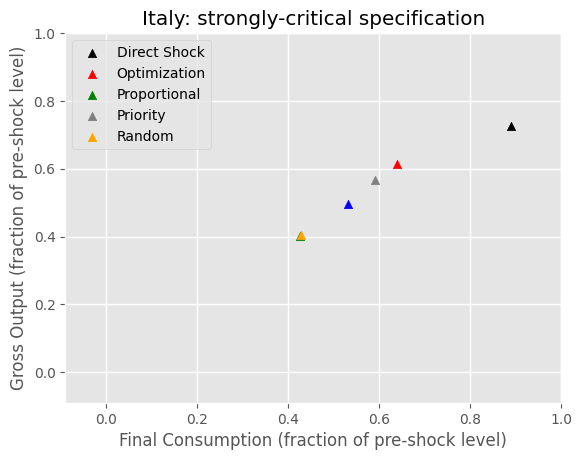

In [34]:
plt.style.use('ggplot')
plt.title("Italy: strongly-critical specification")
plt.grid(visible=None, which='major', axis='both', linestyle='-', linewidth=1)

plt.scatter(direct_shock[1], direct_shock[0], marker = '^', color= 'black')
plt.scatter(Max_consumption[1], Max_consumption[0], marker = '^', color= 'red')
plt.scatter(result_proportional[1], result_proportional[0], marker = '^', color= 'green')
plt.scatter(result_mixed[1], result_mixed[0], marker = '^', color= 'gray')
plt.scatter(result_priority[1], result_priority[0], marker = '^', color= 'orange')
plt.scatter(result_random[1], result_random[0], marker = '^', color= 'blue')


plt.legend(['Direct Shock', 'Optimization', 'Proportional', 'Priority', 'Random'])

plt.xlim(-0.09,1) 
plt.ylim(-0.09,1)

plt.xlabel("Final Consumption (fraction of pre-shock level)")
plt.ylabel("Gross Output (fraction of pre-shock level)")
plt.savefig('plot_Italy_strongly_critical.png')
plt.show()